#                            Pengenalan Emosi Seseorang Menggunakan Suara

Maulana Kavaldo | Agustus 2022

<p><img alt="Insight logo" src="images/social-github.png" align="left" width="25px" height="25px"></p>
<span><a href="https://maulanakavaldo.github.io">Maulana Kavaldo</a> </span>

<p><img alt="Insight logo" src="images/sm-link.png" align="left" width="24px" height="24px"></p>
<span><a href="https://linkedin.com/in/maulana-kavaldo">Maulana Kavaldo</a> </span> 

<!-- <p><img alt="Insight logo" src="images/sm-ig.png" align="left" width="25px" height="25px"></p> -->
_______

## Introduction

Tujuan dari project ini untuk melakukan klasifikasi emosi seseorang dengan menggunakan suara berupa hasil rekaman. Berbicara merupakan suatu cara yang umum untuk mengungkapkan suatu ekspresi atau juga emosi. Suara dapat memberikan gambaran bagaimana emosi seseorang yang berdasar pada nada dan pitch.

## Librosa

Library yang paling penting dalam pengerjaan project ini. Digunakan untuk melakukan analisis dan klasifikasi dataset berupa suara.

## Dataset 

### RAVDESS

Dataset diambil pada link: https://zenodo.org/record/1188976#.XwTpxShKjIV. File yang digunakan 'Audio_Speech_Actors_01-24.zip'.<br> 


### Filename identifiers 

1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only)
2. Vocal channel (01 = speech, 02 = song).
3. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
4. Emotional intensity (01 = normal, 02 = strong). 
5. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
6. Repetition (01 = 1st repetition, 02 = 2nd repetition).

### TESS
Dataset diambil pada link: https://tspace.library.utoronto.ca/handle/1807/24487.

### Filename identifiers
1. Actor ( OAF = Older actor, YAF = Younger actor)
2. Target word (Ex: Back, Bar, Base, Bath, Bean)
3. emotion (Ex: angry, disgust, fear, happy, neutral, sad)<br>


Kedua dataset tersebut digunakan untuk training model dan meningkatkan akurasi dari model yang akan dibuat.

## Process Flow

__Langkah-langkah pengerjaan project:__ 

__1. Data preparation__: Mengumpulkan dan memanipulasi data untuk menghasilkan informasi.


__2. Feature extraction__: Melakukan ekstraksi pada dataset dan dilakukan processing.


__3. Building a model__: Menggunakan model untuk melakukan klasifikasi emosi-emosi pada data. 


__4. Testing the model__: Testing pada data baru.

In [1]:
# !pip install librosa

In [19]:
import os
import glob 
import librosa 
import librosa.display 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import IPython.display as ipd
import sklearn
from sklearn import preprocessing 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn import metrics 

## 1. Data Preparation

### RAVDESS

In [20]:
#mendefinisakan emosi
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'   
}
gender=[]
emotion=[]
for file in glob.glob("E:/GitHub-Oth/.dataset/Audio_Speech_Actors_01-24/Actor_*/*.wav"): 
        file_name=os.path.basename(file) #mendapatkan file dari path
        temp=emotions[file_name.split("-")[2]] #mendapatkan emosi dari filename
        emotion.append(temp)
        temp=int(file_name.split("-")[5]) #mendapatkan gender dari filename
        if temp%2 == 0:
            temp="female"
        else:
            temp="male"
        gender.append(temp)

In [21]:
temp1=pd.DataFrame(emotion) #membuat temp dataframe untuk emosi
temp2=pd.DataFrame(gender) #membuat temp dataframe untuk gender
df=pd.concat([temp2,temp1],axis=1) #menggabungkan 2 dataframe
df.columns=['gender','emotion']
df['gender_emotion'] =df.gender + '_' + df.emotion #menggabungkan gender and emosi
df.head()

,gender,emotion,gender_emotion
0,male,neutral,male_neutral
1,female,neutral,female_neutral
2,male,neutral,male_neutral
3,female,neutral,female_neutral
4,male,calm,male_calm


In [22]:
print(df.gender_emotion.value_counts()) #melihat jumlah file yang berbeda dari kolom "gender_emotion"

male_calm           96
female_calm         96
male_happy          96
female_happy        96
male_sad            96
female_sad          96
male_angry          96
female_angry        96
male_fearful        96
female_fearful      96
male_disgust        96
female_disgust      96
male_surprised      96
female_surprised    96
male_neutral        48
female_neutral      48
Name: gender_emotion, dtype: int64


### TESS

Sama seperti langkah sebelumnya, namun pada dataset yang berbeda.

In [23]:
speaker=[]
emotion=[]
for file in glob.glob("E:/GitHub-Oth/.dataset/Toronto emotional speech set (TESS) - Older talker_Happy/*_*_*.wav"):
    file_name=os.path.basename(file)
    temp=file_name.split("_")[2] 
    temp=temp.replace('.wav','') #mengganti ".wav"
    emotion.append(temp)
    temp1=file_name.split("_")[0] #speaker
    speaker.append(temp1)    
temp1=pd.DataFrame(emotion) #temp emotion
temp2=pd.DataFrame(speaker) #temp speaker
df=pd.concat([temp2,temp1],axis=1) #menggabungkan 2 dataframe
df.columns=['gender','speaker']
df['gender_speaker'] =df.gender + '_' + df.speaker #menggabungkan gender dan emotion
df.head()

,gender,speaker,gender_speaker
0,OAF,happy,OAF_happy
1,OAF,happy,OAF_happy
2,OAF,happy,OAF_happy
3,OAF,happy,OAF_happy
4,OAF,happy,OAF_happy


In [24]:
print(df.gender_speaker.value_counts()) #melihat jumlah baris yang berbeda dari kolom "gender_speaker"

OAF_happy    200
Name: gender_speaker, dtype: int64


## 2.Feature extraction

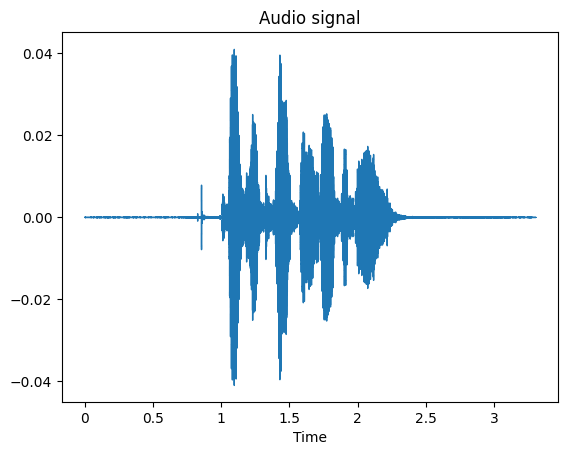

In [26]:
voice,sr = librosa.load("E:/GitHub/.dataset/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav")

librosa.display.waveshow(voice, sr=sr) 
plt.title('Audio signal')
ipd.Audio(voice, rate=sr) 

(128, 143)


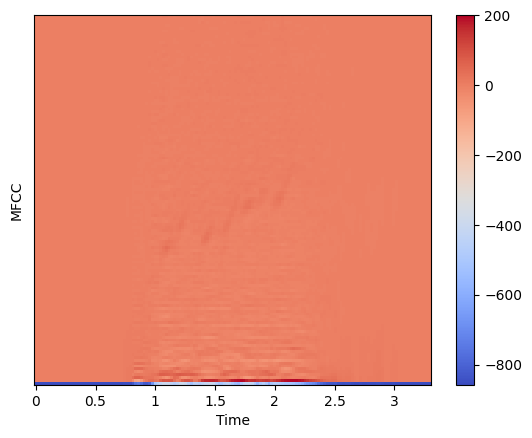

In [27]:
mfcc = librosa.feature.mfcc(y=voice, sr=sr, n_mfcc=128) #nomor fitur MFCC 128
print(mfcc.shape)
librosa.display.specshow(mfcc, x_axis='time') #menampilkan plot MFCC
plt.ylabel('MFCC')
plt.colorbar()

In [28]:
print(mfcc)

[[-857.354 -857.354 -857.354 ... -857.354 -857.354 -857.354]
 [   0.       0.       0.    ...    0.       0.       0.   ]
 [   0.       0.       0.    ...    0.       0.       0.   ]
 ...
 [   0.       0.       0.    ...    0.       0.       0.   ]
 [   0.       0.       0.    ...    0.       0.       0.   ]
 [   0.       0.       0.    ...    0.       0.       0.   ]]


### Mel scale

(128, 143)


Text(0.5, 1.0, 'Melspectrogram')

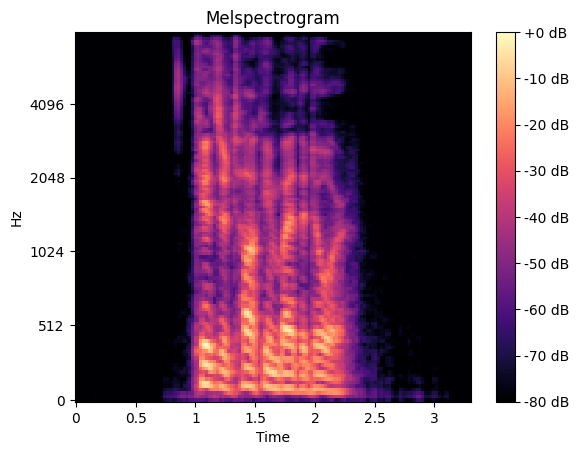

In [29]:
mel=librosa.feature.melspectrogram(y=voice, sr=sr) #melakukan ekstrak melspectrogram dari audio signal
mel_dB = librosa.power_to_db(mel, ref=np.max) #konvesi ke decibel 
print(mel_dB.shape) 
librosa.display.specshow(mel_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000) # menampilkan melspectrogram
plt.colorbar(format='%+2.0f dB')
plt.title('Melspectrogram')

## 3.Building the Model

In [30]:
def features(file):
    X,sr = librosa.load(file) 
    feature=np.array([]) 
    mfcc=np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=128), axis=1) #mengambil nilai rata-rata
    feature=np.hstack((feature, mfcc)) #horizontal stack untuk mengkombinasi fitur
    mel=np.mean(librosa.feature.melspectrogram(X, sr=sr),axis=1)
    feature=np.hstack((feature, mel)) 
    return feature

In [34]:
# known_emotions=['calm', 'happy', 'fearful', 'disgust']

In [ ]:
x,y=[],[]
for file in glob.glob("E:/GitHub-Oth/.dataset/Audio_Speech_Actors_01-24/Actor_*/*.wav"): 
    file_name=os.path.basename(file)
    feature=features(file) #memanggil fungsi features()
    emotion=emotions[file_name.split("-")[2]]
   #  if emotion not in known_emotions:
   #     continue
    x.append(feature)
    y.append(emotion)

Terdapat perbedaan pada dua dataset dimana pemetaan/definisi emosi yang berbeda, sehingga harus disamakan.

In [ ]:
change = {'fear'} 
change1 = {'ps'}
for file in glob.glob("E:/GitHub-Oth/.dataset/Toronto emotional speech set (TESS) - Older talker_Happy/*_*_*.wav"):
    file_name=os.path.basename(file) 
    feature=features(file) #
    emotion=file_name.split("_")[2] 
    emotion=emotion.replace('.wav','')
    if emotion in change:
        emotion=emotion.replace('fear','fearful') 
    if emotion in change1:
        emotion=emotion.replace('ps','surprised')
    # if emotion not in known_emotions:
    #    continue
    x.append(feature)
    y.append(emotion)

In [41]:
len(x) #panjang semua fitur

1640

## Multi Layer Perceptron (MLP)

> alpha=0.01, batch_size=256,epsilon=1e-08, hidden_layer_sizes=(300,),learning_rate='adaptive', max_iter=500

In [43]:
x_train,x_test,y_train,y_test=train_test_split(np.array(x), y, test_size=0.2, random_state=9) #80% train dan 20% test
model=MLPClassifier(alpha=0.01, batch_size=256,epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500,random_state=123)
model.fit(x_train,y_train) #fitting model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500, random_state=9)

### Parameters MLP classifier:

<div class="text-justify">

__1. Jumlah Lapisan (Number of Layers)__ <br>
Jumlah lapisan dalam MLP harus dipilih dengan hati-hati, karena terlalu sedikit lapisan dapat menyebabkan underfitting, sedangkan terlalu banyak lapisan dapat menyebabkan overfitting.

__2. Jumlah Neuron dalam setiap Lapisan (Number of Neurons in Each Layer)__ <br>
    Jumlah neuron dalam setiap lapisan MLP dapat mempengaruhi kinerja model. Terlalu sedikit neuron dapat menyebabkan underfitting, sedangkan terlalu banyak neuron dapat menyebabkan overfitting.

__3. Fungsi Aktivasi (Activation Function)__ <br>
    Fungsi aktivasi digunakan untuk menghitung output dari setiap neuron di dalam jaringan. Beberapa contoh fungsi aktivasi yang umum digunakan adalah ReLU, Sigmoid, dan Tanh.

__4. Learning Rate__ <br>
    Learning rate adalah parameter yang menentukan seberapa besar perubahan bobot yang terjadi pada setiap iterasi selama proses training. Jika learning rate terlalu besar, maka model dapat mengalami divergensi, sedangkan jika terlalu kecil, maka model dapat mengalami konvergensi yang lambat.

__5. Epochs__ <br>
    Epochs adalah jumlah iterasi yang dilakukan selama proses training. Jumlah epochs yang tepat tergantung pada ukuran data dan kompleksitas model.

__6. Batch Size__ <br>
    Batch size adalah jumlah sampel data yang diambil dalam satu iterasi. Batch size yang terlalu besar dapat menyebabkan kekurangan memori, sedangkan batch size yang terlalu kecil dapat menghasilkan hasil yang tidak stabil.

__7. Optimizer__ <br>
    Optimizer digunakan untuk mengoptimalkan model dengan menyesuaikan bobot pada setiap iterasi. Beberapa contoh optimizer yang umum digunakan adalah Stochastic Gradient Descent (SGD), Adam, dan RMSProp.

<div>

In [44]:
y_pred=model.predict(x_test) #prediksi test data
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred) 
report=metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       angry       0.47      0.68      0.56        25
        calm       0.67      0.67      0.67        36
     disgust       0.89      0.21      0.34        38
     fearful       0.81      0.56      0.67        39
       happy       0.73      0.86      0.79        90
     neutral       0.36      0.50      0.42        20
         sad       0.57      0.61      0.59        33
   surprised       0.69      0.74      0.71        47

    accuracy                           0.65       328
   macro avg       0.65      0.60      0.59       328
weighted avg       0.69      0.65      0.64       328



In [55]:
print("Accuracy: {:.2f}".format(accuracy*100)+"%") 

Accuracy: 64.94%


## 4. Testing the Model

In [47]:
path = "E:/GitHub-Oth/.dataset/Toronto emotional speech set (TESS) - Older talker_Happy/OAF_back_happy.wav"
test = features(path)
voice,sr = librosa.load(path)
test = test.reshape(1,-1) #reshape 2D array
pred=model.predict(test) #prediksi emosi
print(pred)
ipd.Audio(voice,rate=sr) #menampilkan play suara

['happy']


C:\Users\Acer\AppData\Local\Temp\ipykernel_13168\2655820447.py:6: FutureWarning: Pass y=[ 0.00011396 -0.00136029 -0.00253447 ...  0.00282335  0.00142893
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sr),axis=1) #taking the mean of all the features row-wisee


In [50]:
path = "E:/GitHub-Oth/.dataset/Audio_Speech_Actors_01-24/Actor_02/03-01-01-01-02-01-02.wav"
test = features(path)
voice,sr = librosa.load(path)
test = test.reshape(1,-1)
pred=model.predict(test) 
print(pred)
ipd.Audio(voice,rate=sr)

C:\Users\Acer\AppData\Local\Temp\ipykernel_13168\2655820447.py:6: FutureWarning: Pass y=[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.11079435e-05
 7.93689196e-06 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sr),axis=1) #taking the mean of all the features row-wisee


['surprised']


## Conclusion

- Project ini berhasil melakukan klasifikasi emosi pada seseorang dengan bantuan dataset berupa hasil rekaman yang diperoleh dari beberapa sumber. Meskipun untuk tingkat akurasi masih belum terlalu tinggi dan diperlukan peningkatan akurasi.
- Project ini kemungkinan besar dapat diterapkan pada model lain, tidak hanya menggunakan MLP saja.
- Pada project ini menggunalan MLP karena memberikan akurasi yang baik dengan mengurangi waktu pelatihan model dan juga GPU.
